# Fantapalla Forever Stats

In [81]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from matplotlib.patches import Patch

from crea_df import storico_individuale

from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
# Set the style globally
plt.style.use('default')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Exo 2'
rcParams['font.weight'] = '500'
#rcParams['font.monospace'] = 'Ubuntu Mono'
rcParams['font.size'] = 16
rcParams['axes.labelsize'] = 16
rcParams['axes.labelweight'] = '500'
rcParams['axes.titleweight'] = '600'
rcParams['axes.titlesize'] = 16
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['legend.fontsize'] = 12
rcParams['figure.titlesize'] = 18


### Init dataframes #########################################################
Teams = {'luca' : ['XYZ', 'darkblue'],
         'franky' : ['Mainz Na Gioia', 'r'],
         'emiliano' : ['I Diseredati', 'skyblue'],
         'nanni' : ['Palla Pazza', 'firebrick'],
         'enzo' : ['AS 800A', 'gold'],
         'pietro' : ['PDG 1908', 'dodgerblue'],
         'musci8' : ['Soros fc', 'lightgreen'],
         'mario' : ['Ignoranza', 'pink'],
        }

Logos = {'luca' : '../Logos/fit/luca.png',
         'franky' : '../Logos/fit/franky.png',
         'nanni' : '../Logos/fit/nanni.png',
         'pietro' : '../Logos/fit/pietro.png',
         'mario' : '../Logos/fit/mario.png',
         'enzo' : '../Logos/fit/enzo.png',
         'musci8' : '../Logos/fit/musci8.png',
         'emiliano' : '../Logos/fit/emiliano.png'}

parameters = [
    'punti_fatti',         # fantapunti realizzati
    'punti_subiti',        # fantapunti subiti
    'goal_subiti_por',     # goal subiti dal portiere che concorre a punteggio squadra
    'cartellini',          # subiti da giocatori che concorrono a punteggio squadra (giallo=1, rosso=2)
    'bonus_panchina',      # somma dei bonus giocatori che non concorrono a punteggio squadra
    'mod_difesa',          # modificatore difesa
    'infortunati'          #infortunati giornata
    #'mod_fairplay'         # modificatore fairplay
]
df = pd.DataFrame(columns=parameters)

df_luca = df
df_franky = df
df_nanni = df
df_pietro = df
df_mario = df
df_enzo = df
df_musci8 = df
df_emiliano = df

Results = {
    'luca' : df_luca,
    'franky' : df_franky,
    'emiliano' : df_emiliano,
    'nanni' : df_nanni,
    'enzo' : df_enzo,
    'pietro' : df_pietro,
    'musci8' : df_musci8,
    'mario' : df_mario,
}

# Steps of scored goals
goal_marks=np.array([66,68,70,72,74,76,78,80,82,84,86,88,90])

### Utility functions ################################################
def get_goal(fp):
    '''Return number of goals given fantapoints'''
    goal_counter = 0
    for mark in goal_marks:
        if fp<mark: return goal_counter
        goal_counter = goal_counter+1
    return goal_counter

def esito(gf,gs):
    '''Return match result (V,P,S) given goal scored and conceded'''
    if gf>gs: return 'V'
    elif gf<gs: return 'S'
    else: return 'P'
    
def punti(esito):
    '''Return standing points given match result'''
    try:
        if esito=='V': return 3
        elif esito=='S': return 0
        elif esito=='P': return 1
    except ValueError:
        print('Esito non valido')

def mod_fairplay(cartellini):
    '''Return modificatore fairplay value given number of yellow/red cards'''
    if cartellini==0: return 1
    return 0

def get_team_colors():
    '''Return list of team colors by default order'''
    colors = []
    for key in Teams.keys():
        colors.append(Teams[key][1])
    return colors
    
def fattore_distacco(Total):
    pf_med = np.median(Total['punti_fatti'])
    pf_std = np.std(Total['punti_fatti'])
    dist_med = np.median(Total['distacco'])
    dist_std = np.std(Total['distacco'])
    pf_rel = (Total['punti_fatti'] - pf_med) / pf_std
    dist_rel = (Total['distacco'] - dist_med) / dist_std
    return -dist_rel-pf_rel

def calc_fortuna(df):
    keys = ('f_pos', 'f_distacco', 'f_GS', 'f_close_games')
    scaling = (0.5, 1, 1, 0.5)
    cols = ['dodgerblue', 'purple', 'r', 'gold']
    factors = []
    df['IndiceFortuna'] = [0,0,0,0,0,0,0,0]
    ### build fortuna
    for col,scale in zip(keys,scaling):
        factors.append(df[col]*scale)
        df['IndiceFortuna'] = df['IndiceFortuna'] + df[col]*scale
    return df, factors

In [83]:
import os

# Stabilisci ultima giornata valida
giornate = len(next(os.walk('Dati_storici/'))[2])

print('Ultima giornata:', giornate)
pd.read_pickle('Dati_storici/Giornata_%d.pkl' % giornate)

Ultima giornata: 5


,IGNORANZA EVERYWHERE,AS 800A,MAINZ NA GIOIA,I DISEREDATI,XYZ,SOROS FC,PALLA PAZZA,PDG 1908
Fantapunti Fatti,69.00,70.25,69.75,70.25,66.00,67.25,68.25,72.75
Fantapunti Subiti,70.25,69.00,70.25,69.75,67.25,66.00,72.75,68.25
Goal subiti,2.00,2.00,2.00,1.00,2.00,3.00,0.00,0.00
C. gialli,1.00,3.00,1.00,0.00,2.00,4.00,2.00,2.00
C. rossi,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
Bonus Panchinari,2.25,0.00,0.50,0.00,0.00,0.00,1.50,0.00
Modificatore,0.00,0.50,0.00,1.00,0.00,0.00,0.50,0.00
tot Infortunati,5.00,5.00,4.00,3.00,4.00,1.00,5.00,3.00


# >>> Fill dataframes <<<

In [84]:
### Fill dataframe per partita #############################
for team, df in Results.items():
    Results[team] = Results[team][0:0]
    
    #Results[team] = pd.read_csv(team+'.txt', sep=' ', names=parameters, skiprows=1)
    
    #################### AGGIUNTO DA LUCA: CREA DIRETTAMENTE I DF USANDO LA FUNZIONE IMPORTATA, NON PIU' LETTI DA PICKLES
    #Results[team] = pd.read_pickle('Dati_individuali/'+team+'.pkl')
    Results[team] = storico_individuale(team, giornate)
    Results[team] = Results[team].drop('gg',axis=1)
    Results[team] = Results[team].drop('nome',axis=1)
    Results[team].columns = parameters
    #####################
    
    Results[team]['mod_fairplay'] = Results[team].apply(lambda x: mod_fairplay(x['cartellini']), axis=1)
    Results[team]['GF'] = Results[team].apply(lambda x: get_goal(x['punti_fatti']), axis=1)
    Results[team]['GS'] = Results[team].apply(lambda x: get_goal(x['punti_subiti']), axis=1)
    Results[team]['esito'] = Results[team].apply(lambda x: esito(x['GF'],x['GS']), axis=1)
    Results[team]['pti'] = Results[team].apply(lambda x: punti(x['esito']), axis=1)
    Results[team] = Results[team].assign(Team=team)    
    
    print('###', team, '|', Teams[team], '###')
    display(Results[team])
    print('\n\n\n')
       
### Global variables #############################
#giornate = max(Results['luca'].index)

### concatenate team dataframes ##################
cdf = pd.concat(Results)
pf_med = np.median(cdf.punti_fatti)
pf_std = np.std(cdf.punti_fatti)
ps_med = np.median(cdf.punti_subiti)
ps_std = np.std(cdf.punti_subiti)
gf_med = np.median(cdf.GF)
gf_std = np.std(cdf.GF)
print('### CUMULATIVE DATA after', giornate, 'rounds ###')
print('Punti Fatti:\n mediana =', pf_med, '\n varianza =', pf_std, 
      #'\nPunti Subiti:\n mediana =', ps_med, '\n varianza =', ps_std, 
      '\nGoal Fatti:\n mediana =', gf_med, '\n varianza =', gf_std
     )



### Total values dataframe #######################
def close_games(verbose=False, data=Results, giornate=max(Results['luca'].index)):
    '''Compute close games per team and add factor to Total dataframe'''
    factor_close_games = []
    for team, df in data.items():
        df = df[df.index <= giornate]
        if verbose: print('\n###', team, '###')
        pti=0
        g = 0
        for gg in df.index:     
            if (np.abs(df['punti_fatti'][gg]-df['punti_subiti'][gg]))<=1.5:
                res = esito(df.GF[gg], df.GS[gg])
                if verbose: print('G', gg, '| punti fatti:', df.punti_fatti[gg], ' ( subiti:', df.punti_subiti[gg],') |', res, '(', df.GF[gg], '-', df.GS[gg], ')')
                pti = pti+punti(res)
                g = g+1
        try:
            if verbose: print('---> %d punti in %d giornate \n     (media: %.2f)' % (pti, g, pti/g))
            factor_close_games.append(pti-g)
        except:
            if verbose: print('---> No close games found')
            factor_close_games.append(0)
    return factor_close_games


def low_scoring_games(verbose=False, data=Results, giornate=max(Results['luca'].index)):
    '''Compute close games per team and add factor to Total dataframe'''
    factor_low_scoring_games = []
    for team, df in data.items():
        df = df[df.index <= giornate]
        if verbose: print('\n###', team, '###')
        pti=0
        g = 0
        for gg in df.index:     
            if df['punti_fatti'][gg] < 62:
                res = esito(df.GF[gg], df.GS[gg])
                if verbose: print('G', gg, '| punti fatti:', df.punti_fatti[gg], ' ( subiti:', df.punti_subiti[gg],') |', res, '(', df.GF[gg], '-', df.GS[gg], ')')
                pti = pti+punti(res)
                g = g+1
        try:
            if verbose: print('---> %d punti in %d giornate \n     (media: %.2f)' % (pti, g, pti/g))
            factor_close_games.append(pti-g)
        except:
            if verbose: print('---> No games found')
            factor_close_games.append(0)
    return factor_low_scoring_games


def exact_fp(verbose=False, data=Results, giornate=max(Results['luca'].index)):
    '''Compute close games per team and add factor to Total dataframe'''
    factor = []
    for team, df in data.items():
        df = df[df.index <= giornate]
        if verbose: print('\n###', team, '###')
        pti=0
        g = 0
        for gg in df.index:     
            if df['punti_fatti'][gg] in goal_marks:
                res = esito(df.GF[gg], df.GS[gg])
                if verbose: print('G', gg, '| punti fatti:', df.punti_fatti[gg], ' ( subiti:', df.punti_subiti[gg],') |', res, '(', df.GF[gg], '-', df.GS[gg], ')')
                if (df.GF[gg] - df.GS[gg]) <= 1:
                    res_ = esito(df.GF[gg]-1, df.GS[gg])
                    pti_ = punti(res_)
                    pti = pti+punti(res)-pti_
                g = g+1
        try:
            if verbose: print('---> %d punti rubati in %d giornate' % (pti, g))
            factor.append(pti)
        except:
            if verbose: print('---> No stolen games found')
            factor.append(0)
    return factor

def opponent_almost_scored(verbose=False, data=Results, giornate=max(Results['luca'].index)):
    '''Compute close games per team and add factor to Total dataframe'''
    factor = []
    for team, df in data.items():
        df = df[df.index <= giornate]
        if verbose: print('\n###', team, '###')
        pti=0
        g = 0
        for gg in df.index:     
            if df['punti_subiti'][gg] in goal_marks-0.5:
                res = esito(df.GF[gg], df.GS[gg])
                if verbose: print('G', gg, '| punti fatti:', df.punti_fatti[gg], ' ( subiti:', df.punti_subiti[gg],') |', res, '(', df.GF[gg], '-', df.GS[gg], ')')
                if (df.GF[gg] - df.GS[gg]) <= 1:
                    res_ = esito(df.GF[gg], df.GS[gg]+1)
                    #print('Actual Result: %s, Potential: %s' % (res, res_))
                    pti_ = punti(res_)
                    pti = pti+punti(res)-pti_
                g = g+1
        try:
            if verbose: print('---> %d punti rubati in %d giornate' % (pti, g))
            factor.append(pti)
        except:
            if verbose: print('---> No stolen games found')
            factor.append(0)
    return factor



def make_Total_df(data=Results, giornate=max(Results['luca'].index)):
    columns = list(data['luca'])
    table = [[]]
    for team,df in data.items():
        df = df[df.index <= giornate]
        values = []
        for col in columns:
            values.append(df[col].sum())
        values[len(values)-1]=team
        table.append(values)
    table=table[1:]
    Total=pd.DataFrame(table,columns=columns)
    # additional columns
    Total = Total.sort_values(by=['punti_fatti'], ascending=False)
    Total['pos'] = Total['pti'].rank(ascending=False, method='first')
    Total['rank'] = Total['punti_fatti'].rank(ascending=False, method='first')
    Total['distacco'] = np.max(Total['pti']) - Total['pti']
    Total['f_pos'] = Total['rank']-Total['pos']
    Total['f_distacco'] = fattore_distacco(Total)
    Total['x_punti_subiti'] = (Total['punti_fatti'].sum() - Total['punti_fatti'])/7
    Total['x_GS'] = (Total['GF'].sum() - Total['GF'])/7
    Total['f_GS'] = -1*(Total['GS']-Total['x_GS'])/np.std(Total['GS'])
    Total.sort_index(inplace=True)
    Total['f_close_games'] = close_games(giornate=giornate)
    Total['f_stolen_games'] = exact_fp(giornate=giornate)
    Total['f_unlucky_opponent'] = opponent_almost_scored(giornate=giornate)
    return Total

#build full Total dataframe
print('... Filling Total df ...')
Total = make_Total_df()

Total.head(10)

### luca | ['XYZ', 'darkblue'] ###


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,bonus_panchina,mod_difesa,infortunati,mod_fairplay,GF,GS,esito,pti,Team
1,72.25,67.5,0,6,0,0,7,0,4,1,V,3,luca
2,77,64.25,2,1,0,0,5,0,6,0,V,3,luca
3,73.5,70.5,1,2,1.75,0,3,0,4,3,V,3,luca
4,65,65,0,2,3,0.5,4,0,0,0,P,1,luca
5,66,67.25,2,2,0,0,4,0,1,1,P,1,luca






### franky | ['Mainz Na Gioia', 'r'] ###


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,bonus_panchina,mod_difesa,infortunati,mod_fairplay,GF,GS,esito,pti,Team
1,70.75,71.75,1,1,0.75,0,3,0,3,3,P,1,franky
2,64.25,77,1,3,0,0,4,0,0,6,S,0,franky
3,69.5,75.75,1,1,1.25,0,3,0,2,5,S,0,franky
4,67.5,68,2,3,1.5,0,4,0,1,2,S,0,franky
5,69.75,70.25,2,1,0.5,0,4,0,2,3,S,0,franky






### emiliano | ['I Diseredati', 'skyblue'] ###


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,bonus_panchina,mod_difesa,infortunati,mod_fairplay,GF,GS,esito,pti,Team
1,67.5,72.25,3,3,1.75,0,3,0,1,4,S,0,emiliano
2,70.25,73,3,1,1.75,1.5,0,0,3,4,S,0,emiliano
3,65.5,73.5,1,0,3,0.5,2,1,0,4,S,0,emiliano
4,67,64.25,0,2,0,0.5,1,0,1,0,V,3,emiliano
5,70.25,69.75,1,2,0,1,3,0,3,2,V,3,emiliano






### nanni | ['Palla Pazza', 'firebrick'] ###


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,bonus_panchina,mod_difesa,infortunati,mod_fairplay,GF,GS,esito,pti,Team
1,71.75,70.75,2,1,3,1,1,0,3,3,P,1,nanni
2,70.5,74.75,3,1,0.75,1,2,0,3,5,S,0,nanni
3,69.75,65.25,0,2,3.25,0,3,0,2,0,V,3,nanni
4,65,65,0,0,0,0,6,1,0,0,P,1,nanni
5,68.25,72.75,0,2,1.5,0.5,5,0,2,4,S,0,nanni






### enzo | ['AS 800A', 'gold'] ###


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,bonus_panchina,mod_difesa,infortunati,mod_fairplay,GF,GS,esito,pti,Team
1,75.5,68.5,2,2,1.5,1,3,0,5,2,V,3,enzo
2,74.5,73.25,0,3,1.5,0.5,4,0,5,4,V,3,enzo
3,73.5,65.5,2,2,2.25,1,1,0,4,0,V,3,enzo
4,68,67.5,1,1,0,0,4,0,2,1,V,3,enzo
5,70.25,69,2,3,0,0.5,5,0,3,2,V,3,enzo






### pietro | ['PDG 1908', 'dodgerblue'] ###


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,bonus_panchina,mod_difesa,infortunati,mod_fairplay,GF,GS,esito,pti,Team
1,68.5,75.5,2,1,1.75,0,5,0,2,5,S,0,pietro
2,73,70.25,2,3,0,0,5,0,4,3,V,3,pietro
3,75.75,69.5,3,1,0,0,6,0,5,2,V,3,pietro
4,67.5,73,0,0,0,0,2,1,1,4,S,0,pietro
5,72.75,68.25,0,2,0,0,3,0,4,2,V,3,pietro






### musci8 | ['Soros fc', 'lightgreen'] ###


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,bonus_panchina,mod_difesa,infortunati,mod_fairplay,GF,GS,esito,pti,Team
1,65.75,79,1,2,0.5,0,4,0,0,7,S,0,musci8
2,73.25,74.5,1,2,0.75,0,2,0,4,5,S,0,musci8
3,65.25,69.75,2,3,0.5,0,2,0,0,2,S,0,musci8
4,64.25,67,0,1,0,0,2,0,0,1,S,0,musci8
5,67.25,66,3,4,0,0,1,0,1,1,P,1,musci8






### mario | ['Ignoranza', 'pink'] ###


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,bonus_panchina,mod_difesa,infortunati,mod_fairplay,GF,GS,esito,pti,Team
1,79,65.75,3,1,0,1,4,0,7,0,V,3,mario
2,74.75,70.5,1,1,3.5,1,3,0,5,3,V,3,mario
3,70.5,73.5,3,4,2,1,4,0,3,4,S,0,mario
4,73,67.5,0,0,2,1,3,1,4,1,V,3,mario
5,69,70.25,2,1,2.25,0,5,0,2,3,S,0,mario






### CUMULATIVE DATA after 5 rounds ###
Punti Fatti:
 mediana = 70.0 
 varianza = 3.6910999376879516 
Goal Fatti:
 mediana = 2.5 
 varianza = 1.8296174463531985
... Filling Total df ...


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,bonus_panchina,mod_difesa,infortunati,mod_fairplay,GF,GS,...,rank,distacco,f_pos,f_distacco,x_punti_subiti,x_GS,f_GS,f_close_games,f_stolen_games,f_unlucky_opponent
0,353.75,334.50,5.0,13.0,4.75,0.5,23.0,0,15,5,...,4.0,4,2.0,0.360006,349.821429,12.428571,1.778948,0,1,0
1,341.75,362.75,7.0,9.0,4.00,0.0,18.0,0,8,19,...,6.0,14,-1.0,-0.682397,351.535714,13.428571,-1.334211,-2,0,0
2,340.50,352.75,8.0,8.0,6.50,3.5,9.0,1,8,14,...,7.0,9,2.0,0.539855,351.714286,13.428571,-0.136842,2,0,0
3,345.25,348.50,5.0,6.0,8.50,2.5,17.0,1,10,12,...,5.0,10,-1.0,-0.139730,351.035714,13.142857,0.273684,0,0,0
4,361.75,343.75,7.0,11.0,5.25,3.0,17.0,0,19,9,...,2.0,0,1.0,0.467538,348.678571,11.857143,0.684211,6,2,2
5,357.50,356.50,7.0,7.0,1.75,0.0,21.0,1,16,16,...,3.0,6,-1.0,-0.443158,349.285714,12.285714,-0.889474,0,0,0
6,335.75,356.25,7.0,12.0,1.75,0.0,11.0,0,5,16,...,8.0,14,0.0,-0.102217,352.392857,13.857143,-0.513158,-1,0,0
7,366.25,347.50,9.0,7.0,9.75,4.0,19.0,1,21,11,...,1.0,6,-2.0,-1.289254,348.035714,11.571429,0.136842,-1,0,0


# [>] Expected Punti/Goal Subiti

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


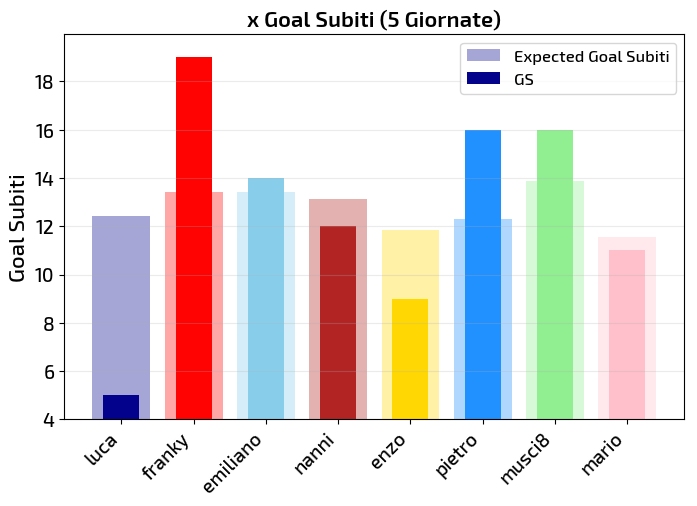

In [85]:
fig = plt.figure(figsize=(8,5))

colors = get_team_colors()

plt.bar(np.arange(0,8), Total['x_GS'], color=colors, alpha=0.35, label='Expected Goal Subiti')
plt.bar(np.arange(0,8), Total['GS'], color=colors, alpha=0.99, width=0.5, label='GS')
xlabels = Total['Team']
plt.xticks(Total.index, xlabels, rotation=45, ha='right')
plt.grid(which='both', axis='y', alpha=0.25)

plt.ylim(ymin = np.min(Total['GS']-1))
plt.ylabel('Goal Subiti')
title = 'x Goal Subiti (' + str(giornate) + ' Giornate)'
plt.title(title)

plt.legend()

plt.show()

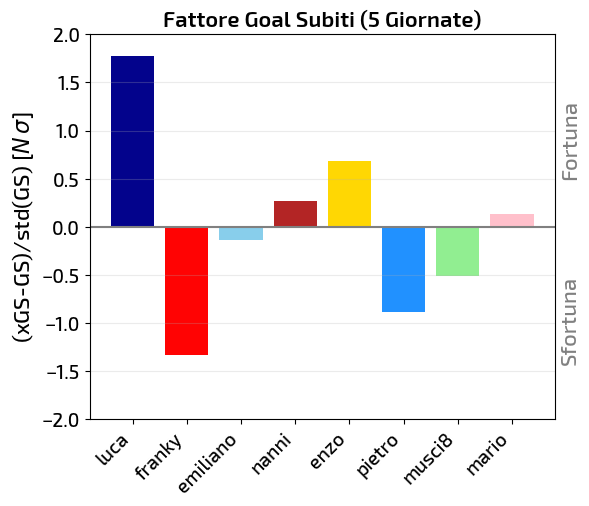

In [86]:
fig = plt.figure(figsize=(6,5))
plt.grid(which='both', axis='y', ls='-', alpha=0.25)

colors = get_team_colors()

std = np.std(Total['GS'])
plt.bar(np.arange(0,8), -1*(Total['GS']-Total['x_GS'])/std, color=colors, alpha=0.99, width=0.8, label='Fattore GS')
xlabels = Total['Team']
plt.xticks(Total.index, xlabels, rotation=45, ha='right')
plt.axhline(y=0, xmin=-100, xmax=100, color='grey', ls='-')
plt.ylim(-2,2)

plt.ylabel('(xGS-GS)/std(GS) [$N\,\sigma$]')
title = 'Fattore Goal Subiti (' + str(giornate) + ' Giornate)'
plt.title(title)

plt.text(x=8.25, y=+0.5, s='Fortuna', verticalalignment='bottom', horizontalalignment='right', color='grey', rotation='90')
plt.text(x=8.25, y=-0.5, s='Sfortuna', verticalalignment='top', horizontalalignment='right', color='grey', rotation='90')


#plt.legend()

plt.show()

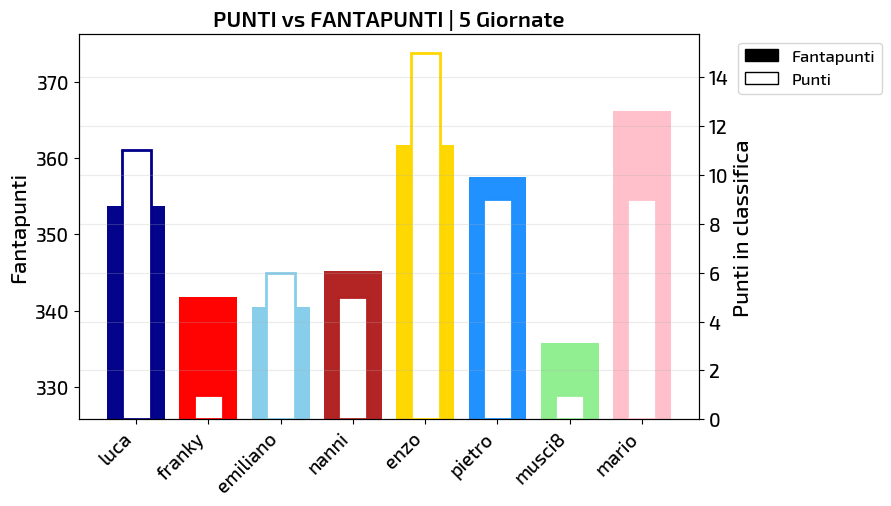

In [87]:
### Punti fatti vs classifica ###############
fig = plt.figure(figsize=(8,5))

colors = get_team_colors()
x = Total['punti_fatti']
y = Total['pti']

plt.bar(np.arange(0,8), x, color=colors, alpha=0.99, label='Expected Goal Subiti')
plt.ylabel('Fantapunti')
plt.ylim(np.min(x)-10, np.max(x)+10)
xlabels = Total['Team']
plt.xticks(Total.index, xlabels, rotation=45, ha='right')

# secondary y axis
ax2 = plt.twinx()
ax2.set_ylabel('Fantapunti')
ax2.tick_params(axis='y', colors='k')
ax2.yaxis.label.set_color('k')
ax2.plot([],[])

plt.bar(np.arange(0,8), y, color='w', edgecolor=colors, alpha=1, width=0.4, lw=2, label='GS')


#plt.xticks(Total.index, xlabels, rotation=45, ha='right')
plt.grid(which='both', axis='y', alpha=0.25)

#plt.ylim(ymin = np.min(Total['GS']-1))
plt.ylabel('Punti in classifica')
title = 'PUNTI vs FANTAPUNTI | ' + str(giornate) + ' Giornate'
plt.title(title)

#legend
legend_elements = [
    Patch(facecolor='k', edgecolor='k', label='Fantapunti'),
    Patch(facecolor='w', edgecolor='k', label='Punti'),
]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05,1))

plt.show()

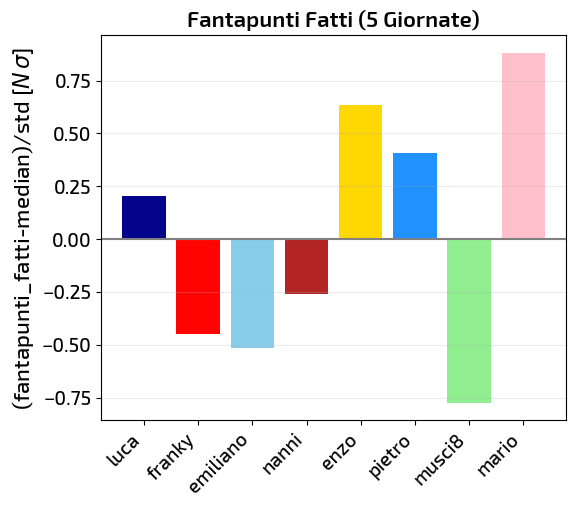

In [88]:
fig = plt.figure(figsize=(6,5))
plt.grid(which='both', axis='y', ls='-', alpha = 0.25)

colors = get_team_colors()
    
std = pf_std*giornate
med = pf_med*giornate

plt.bar(np.arange(0,8), (Total['punti_fatti']-med)/std, color=colors, alpha=0.99, width=0.8, label='')
xlabels = Total['Team']
plt.xticks(Total.index, xlabels, rotation=45, ha='right')
plt.axhline(y=0, xmin=-100, xmax=100, color='grey', ls='-')
#plt.ylim(-2,2)

plt.ylabel('(fantapunti_fatti-median)/std [$N\,\sigma$]')
title = 'Fantapunti Fatti (' + str(giornate) + ' Giornate)'
plt.title(title)

plt.show()

# [>] Close games

In [89]:
close_games(verbose=True)


### luca ###
G 4 | punti fatti: 65.0  ( subiti: 65.0 ) | P ( 0 - 0 )
G 5 | punti fatti: 66.0  ( subiti: 67.25 ) | P ( 1 - 1 )
---> 2 punti in 2 giornate 
     (media: 1.00)

### franky ###
G 1 | punti fatti: 70.75  ( subiti: 71.75 ) | P ( 3 - 3 )
G 4 | punti fatti: 67.5  ( subiti: 68.0 ) | S ( 1 - 2 )
G 5 | punti fatti: 69.75  ( subiti: 70.25 ) | S ( 2 - 3 )
---> 1 punti in 3 giornate 
     (media: 0.33)

### emiliano ###
G 5 | punti fatti: 70.25  ( subiti: 69.75 ) | V ( 3 - 2 )
---> 3 punti in 1 giornate 
     (media: 3.00)

### nanni ###
G 1 | punti fatti: 71.75  ( subiti: 70.75 ) | P ( 3 - 3 )
G 4 | punti fatti: 65.0  ( subiti: 65.0 ) | P ( 0 - 0 )
---> 2 punti in 2 giornate 
     (media: 1.00)

### enzo ###
G 2 | punti fatti: 74.5  ( subiti: 73.25 ) | V ( 5 - 4 )
G 4 | punti fatti: 68.0  ( subiti: 67.5 ) | V ( 2 - 1 )
G 5 | punti fatti: 70.25  ( subiti: 69.0 ) | V ( 3 - 2 )
---> 9 punti in 3 giornate 
     (media: 3.00)

### pietro ###
---> No close games found

### musci8 ###
G 2

[0, -2, 2, 0, 6, 0, -1, -1]

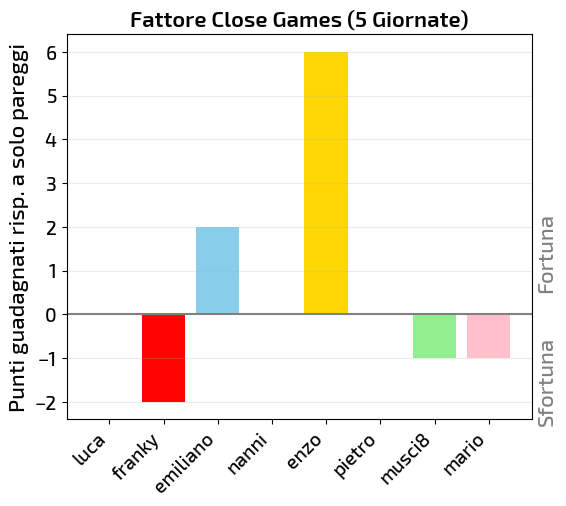

In [90]:
fig = plt.figure(figsize=(6,5))
plt.grid(which='major', axis='y', ls='-', alpha=0.25)

colors = get_team_colors()

plt.bar(np.arange(0,8), Total['f_close_games'], color=colors, alpha=0.99, width=0.8, label='')
xlabels = Total['Team']
plt.xticks(Total.index, xlabels, rotation=45, ha='right')
plt.axhline(y=0, xmin=-100, xmax=100, color='grey', ls='-')

ylim = np.max(np.abs(Total['f_close_games']))*1.1
#plt.ylim(-2.1,2.1)

plt.ylabel('Punti guadagnati risp. a solo pareggi')
title = 'Fattore Close Games (' + str(giornate) + ' Giornate)'
plt.title(title)

plt.text(x=8.25, y=+0.5, s='Fortuna', verticalalignment='bottom', horizontalalignment='right', color='grey', rotation='90')
plt.text(x=8.25, y=-0.5, s='Sfortuna', verticalalignment='top', horizontalalignment='right', color='grey', rotation='90')

plt.show()

In [91]:
### Stolen Games #########################
exact_fp(verbose=True)


### luca ###
G 5 | punti fatti: 66.0  ( subiti: 67.25 ) | P ( 1 - 1 )
---> 1 punti rubati in 1 giornate

### franky ###
---> 0 punti rubati in 0 giornate

### emiliano ###
---> 0 punti rubati in 0 giornate

### nanni ###
---> 0 punti rubati in 0 giornate

### enzo ###
G 4 | punti fatti: 68.0  ( subiti: 67.5 ) | V ( 2 - 1 )
---> 2 punti rubati in 1 giornate

### pietro ###
---> 0 punti rubati in 0 giornate

### musci8 ###
---> 0 punti rubati in 0 giornate

### mario ###
---> 0 punti rubati in 0 giornate


[1, 0, 0, 0, 2, 0, 0, 0]

In [92]:
### Unlucky opponent ###########################
opponent_almost_scored(verbose=True)


### luca ###
G 1 | punti fatti: 72.25  ( subiti: 67.5 ) | V ( 4 - 1 )
---> 0 punti rubati in 1 giornate

### franky ###
---> 0 punti rubati in 0 giornate

### emiliano ###
G 3 | punti fatti: 65.5  ( subiti: 73.5 ) | S ( 0 - 4 )
---> 0 punti rubati in 1 giornate

### nanni ###
---> 0 punti rubati in 0 giornate

### enzo ###
G 3 | punti fatti: 73.5  ( subiti: 65.5 ) | V ( 4 - 0 )
G 4 | punti fatti: 68.0  ( subiti: 67.5 ) | V ( 2 - 1 )
---> 2 punti rubati in 2 giornate

### pietro ###
G 1 | punti fatti: 68.5  ( subiti: 75.5 ) | S ( 2 - 5 )
G 3 | punti fatti: 75.75  ( subiti: 69.5 ) | V ( 5 - 2 )
---> 0 punti rubati in 2 giornate

### musci8 ###
---> 0 punti rubati in 0 giornate

### mario ###
G 3 | punti fatti: 70.5  ( subiti: 73.5 ) | S ( 3 - 4 )
G 4 | punti fatti: 73.0  ( subiti: 67.5 ) | V ( 4 - 1 )
---> 0 punti rubati in 2 giornate


[0, 0, 0, 0, 2, 0, 0, 0]

# <<<<< Indice Fortuna >>>>>

In [93]:
def get_bigradient_colors():
    colors = []
    edgecolors = []
    for key in Teams.keys():
        x = Total[Total['Team']==key]['IndiceFortuna'].sum()
        if Total[Total['Team']==key]['IndiceFortuna'].sum() >= 0:
            x = (max_f - Total[Total['Team']==key]['IndiceFortuna'].sum())/max_f
            s = (x,1,x)
            colors.append(s)
            edgecolors.append('g')
            #edgecolors.append('limegreen')
        else: 
            x = -(Total[Total['Team']==key]['IndiceFortuna'].sum() - min_f)/min_f
            s=(1,x,x)
            colors.append(s)
            #edgecolors.append('orangered')
            edgecolors.append('r')
    return colors, edgecolors

# Take negative and positive data apart and cumulate
def get_cumulated_array(data, **kwargs):
    cum = data.clip(**kwargs)
    cum = np.cumsum(cum, axis=0)
    d = np.zeros(np.shape(data))
    d[1:] = cum[:-1]
    return d 


tot_giornate = 28

keys = ('f_pos', 'f_distacco', 'f_GS', 'f_close_games', 'f_stolen_games', 'f_unlucky_opponent')
scaling = (0.5, 1, 1, 0.5, 0.25*tot_giornate/giornate, 0.25*tot_giornate/giornate)
#scaling = (10.5, 1, 1, 0.5, 0.25, 0.25)

cols = ['dodgerblue', 'purple', 'r', 'gold', 'c', 'lime']
#keys = ('f_distacco', 'f_GS', 'f_closegames')
#scaling = (1, 1, 0.5)
#cols = ['dodgerblue', 'purple', 'gold']

'''
def calc_fortuna(df):
    factors = []
    df['IndiceFortuna'] = [0,0,0,0,0,0,0,0]
    ### build fortuna
    for col,scale in zip(keys,scaling):
        factors.append(df[col]*scale)
        df['IndiceFortuna'] = df['IndiceFortuna'] + df[col]*scale
    #print(len(factors))
    return df, factors
'''

    


"\ndef calc_fortuna(df):\n    factors = []\n    df['IndiceFortuna'] = [0,0,0,0,0,0,0,0]\n    ### build fortuna\n    for col,scale in zip(keys,scaling):\n        factors.append(df[col]*scale)\n        df['IndiceFortuna'] = df['IndiceFortuna'] + df[col]*scale\n    #print(len(factors))\n    return df, factors\n"

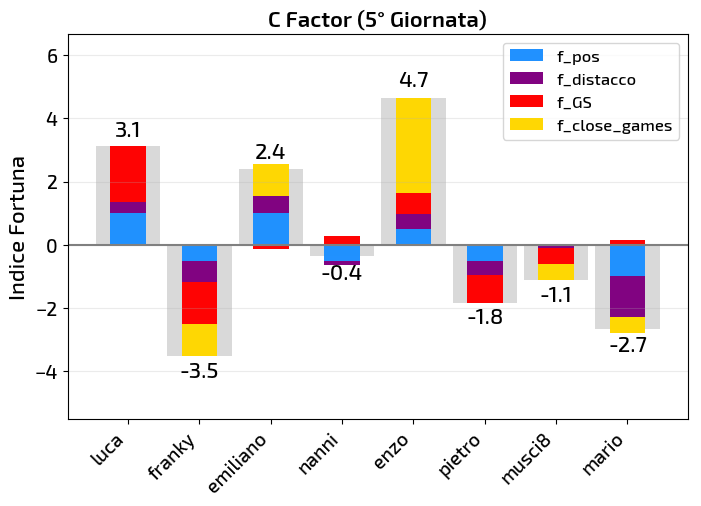

In [94]:
#--- Fortuna Total
Total, __factors__ = calc_fortuna(Total)
matchday = giornate
data_per_round = make_Total_df(giornate = matchday)
__df__, __factors__ = calc_fortuna(data_per_round)



# re-shape data for positive-negative bar plot
__data__ = np.array(__factors__)
#print(__data__)
data_shape = np.shape(__data__)
#print(data_shape)
cumulated_data = get_cumulated_array(__data__, min=0)
cumulated_data_neg = get_cumulated_array(__data__, max=0)
# Re-merge negative and positive data.
row_mask = (__data__<0)
cumulated_data[row_mask] = cumulated_data_neg[row_mask]
data_stack = cumulated_data
#print(np.shape(data_stack))



fig = plt.figure(figsize=(8,5))
plt.grid(which='major', axis='y', ls='-', alpha=0.25)
xlabels = __df__['Team']
plt.xticks(__df__.index, xlabels, rotation=45, ha='right')
plt.axhline(y=0, xmin=-100, xmax=100, color='grey', ls='-')

max_f = max(__df__['IndiceFortuna'])
min_f = np.min(__df__['IndiceFortuna'])
colors, edgecolors = get_bigradient_colors()
plt.bar(np.arange(0,8), __df__['IndiceFortuna'], color='black', edgecolor=edgecolors, lw=0, alpha=0.15, width=0.9, label='')

#print(np.arange(0, data_shape[0]))

for i in np.arange(0, data_shape[0]):
    plt.bar(np.arange(data_shape[1]), __data__[i], bottom=data_stack[i], color=cols[i],alpha=0.99, width=0.5, label=keys[i])
    
plt.legend()

for i, f in enumerate(list(np.round(__df__['IndiceFortuna'],decimals=1))):
    if f<0: 
        va = 'top'
        offset = -0.2
    else: 
        va = 'bottom'
        offset = 0.2
    plt.annotate(f, (i, f+offset), horizontalalignment='center', verticalalignment=va)
    
plt.ylim(min_f-2, max_f+2)

plt.ylabel('Indice Fortuna')
title = 'C Factor (' + str(matchday) + '° Giornata)'
plt.title(title)
plt.show()



#Total.head(10)

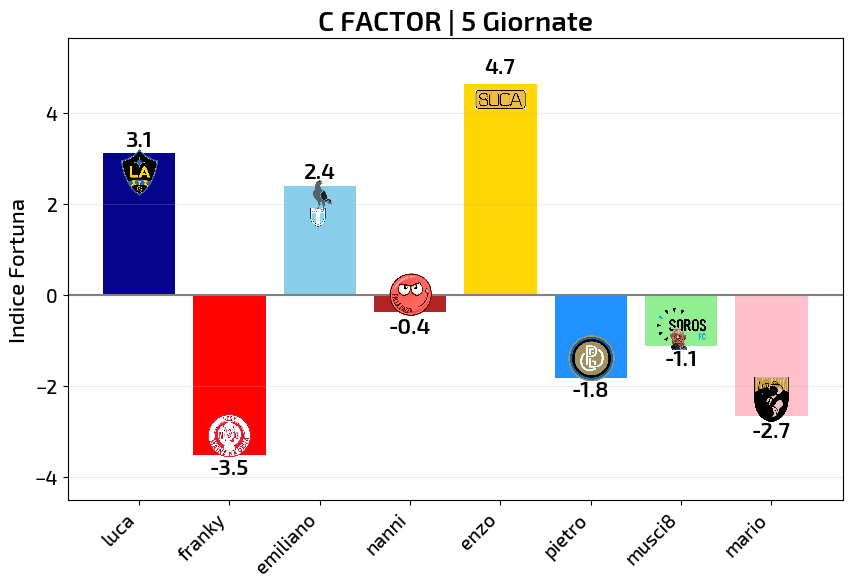

In [95]:
from matplotlib.offsetbox import OffsetImage,AnnotationBbox

def offset_image(x,y, name, ax, zoom):
    img = plt.imread(Logos[name])
    im = OffsetImage(img, zoom=zoom)
    im.image.axes = ax

    ab = AnnotationBbox(im, (x, y),  xybox=(0., 0.), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)

    ax.add_artist(ab)


fig = plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)

plt.grid(which='major', axis='y', ls='-', alpha=0.25)
#xlabels = Total['Team']
plt.xticks(Total.index, xlabels, rotation=45, ha='right')
plt.axhline(y=0, xmin=-100, xmax=100, color='grey', ls='-')

max_f = max(Total['IndiceFortuna'])
min_f = np.min(Total['IndiceFortuna'])
colors = get_team_colors()
ax.bar(np.arange(0,8), Total['IndiceFortuna'], color=colors, lw=0, alpha=0.99, width=0.8, label='')

for i, f in enumerate(list(np.round(Total['IndiceFortuna'],decimals=1))):
    if f<0: 
        va = 'top'
        offset = -0.1
    else: 
        va = 'bottom'
        offset = 0.1
    plt.annotate(f, (i, f+offset), horizontalalignment='center', verticalalignment=va, weight='bold')
    offset_image(i,f-4*offset, Total['Team'].iat[i], ax, zoom=0.15)
    
plt.ylim(min_f-1, max_f+1)
plt.ylabel('Indice Fortuna')
title = 'C FACTOR | ' + str(giornate) + ' Giornate'
plt.title(title, fontsize=20)



    
ax.tick_params(axis='x', which='major')
#for i, team in enumerate(Teams.keys()):
#    offset_image(i, team, ax)


plt.show()

In [96]:
#--- build partial Total entries
print('... Filling Total df per round ...')
Tot_per_round = []
for gg in Results['luca'].index:
    data_per_round = make_Total_df(giornate = gg)
    #print(data_per_round.dtypes)
    __df__, __factors__ = calc_fortuna(data_per_round)
    Tot_per_round.append(__df__)

... Filling Total df per round ...


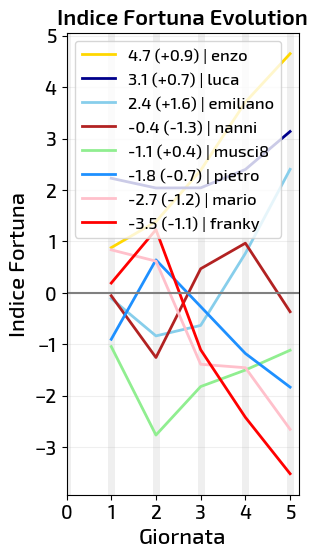

In [97]:
def fortuna_evo(title='Indice Fortuna Evolution', ylabel='Indice Fortuna'):

    giornate = Results['luca'].index
    gg = max(giornate)
    fig = plt.figure(figsize=(gg*0.6,6))

    data = []
    for team in Teams.keys():
        dd = pd.DataFrame()
        score = 0
        scores = []
        for df in Tot_per_round:
            _ = df[df['Team'] == team]
            score = _['IndiceFortuna'].sum()
            #print(team, score)
            scores.append(score)
        dd['score'] = scores
        dd['Team'] = team
        data.append(dd)

    data = sorted(data,key=lambda x:x.at[gg-1,'score'].min(axis=0), reverse=True)

    for df in data:
        team = df['Team'].unique()[0]
        color = Teams[team][1]
        score = df.at[gg-1, 'score']
        score_prev = df.at[gg-2, 'score']
        diff = score - score_prev
        if diff > 0: sign='+'
        else: sign=''
        label = '%.1f (%s%.1f) | %s' % (score, sign, diff, team)
        p = plt.plot(giornate, df['score'], color=color, ls='-', lw=2, label=label)

    plt.xticks(np.arange(0,gg+1))
    plt.grid(axis='x', linestyle='-', linewidth=5, alpha=0.2)
    plt.grid(axis='y', alpha=0.2)
    plt.axhline(0, color='grey')
    plt.xlabel('Giornata')
    plt.ylabel(ylabel)
    plt.title(title)

    plt.legend(loc="upper left")
    plt.show()
    
fortuna_evo()

In [98]:
Tot_per_round[1].keys()

Index(['punti_fatti', 'punti_subiti', 'goal_subiti_por', 'cartellini',
       'bonus_panchina', 'mod_difesa', 'infortunati', 'mod_fairplay', 'GF',
       'GS', 'esito', 'pti', 'Team', 'pos', 'rank', 'distacco', 'f_pos',
       'f_distacco', 'x_punti_subiti', 'x_GS', 'f_GS', 'f_close_games',
       'f_stolen_games', 'f_unlucky_opponent', 'IndiceFortuna'],
      dtype='object')

# [>] Premi Ignobel

In [99]:
def premio_plot(par = 'goal_subiti_por', threshold=2, title='Premio Porta Violata "Mario Bruno"', ylabel='Goal subiti dal portiere', integer=True):
    gg = np.max([giornate+1,5])
    figsizex = np.max([gg,12])
    fig = plt.figure(figsize=(figsizex*0.6,6))
    ax=fig.add_subplot(111)  
    
    giornate_ = Results['luca'].index

    data = []
    for team, df in Results.items():
        if integer: df[par] = df[par].astype(int)
        df['cumsum'] = np.cumsum(df[par])
        score = max(df['cumsum'])
        df['score'] = score
        
        df_prev = df.drop(df.tail(1).index)         
        df_prev['cumsum_prev'] = np.cumsum(df_prev[par])
        score_prev = max(df_prev['cumsum'])
        df['score_prev'] = score_prev
                
        data.append(df)
    data = sorted(data,key=lambda x:x['score'].unique().min(axis=0), reverse=True)

    for df in data:
        team = df['Team'].unique()[0]
        color = Teams[team][1]
        df['cumsum'] = np.cumsum(df[par])
        score = max(df['cumsum'])
        score_prev = max(df['score_prev'])
        diff = score - score_prev
        p = ax.plot(giornate_, df['cumsum'], color=color, alpha=0.75, ls='-', lw=2, label=str(score)+'   | +'+str(diff)+' |   '+str(team))
        #col = p[0].get_color()
        offset_image(giornate_[-1]+0.02*figsizex, df['cumsum'].iat[-1], team, ax, zoom=0.1)
        
        gior = df[df[par]>threshold].index
        dd = df[df.index.isin(gior)]
        marks = dd['cumsum']

        #cs = np.cumsum(dd[par])
        if integer: fs=14
        else: fs=10
        ax.scatter(gior, marks, edgecolor=color, facecolor=color, s=300, label='')
        for x,y,text in zip(gior,marks,dd[par]):
            ax.text(x, y,text, horizontalalignment='center', verticalalignment='center', color='white', fontsize=fs)

    plt.xticks(np.arange(0,gg+1))
    ax.grid(axis='x', linestyle='-', linewidth=5, alpha=0.2)
    ax.set_xlabel('Giornata')
    ax.set_ylabel(ylabel)
    ax.set_xlim(left=0.5)
    ax.set_title(title, fontsize=20)

    
    
  
    
    import matplotlib.lines
    from matplotlib.transforms import Bbox, TransformedBbox
    from matplotlib.legend_handler import HandlerBase
    from matplotlib.image import BboxImage

    class HandlerLineImage(HandlerBase):

        def __init__(self, path, space=15, offset = 10 ):
            self.space=space
            self.offset=offset
            self.image_data = plt.imread(path)        
            super(HandlerLineImage, self).__init__()

        def create_artists(self, legend, orig_handle,
                           xdescent, ydescent, width, height, fontsize, trans):

            l = matplotlib.lines.Line2D([xdescent+self.offset,xdescent+(width-self.space)/3.+self.offset],
                                         [ydescent+height/2., ydescent+height/2.])
            l.update_from(orig_handle)
            l.set_clip_on(False)
            l.set_transform(trans)

            bb = Bbox.from_bounds(xdescent +(width+self.space)/3.+self.offset,
                                  ydescent,
                                  height*self.image_data.shape[1]/self.image_data.shape[0],
                                  height)

            tbb = TransformedBbox(bb, trans)
            image = BboxImage(tbb)
            image.set_data(self.image_data)

            self.update_prop(image, orig_handle, legend)
            return [l,image]


    handles, labels = ax.get_legend_handles_labels()
    print(labels)

    #plt.legend([line, line2], ["", ""],
    #   handler_map={ line: HandlerLineImage("icon1.png"), line2: HandlerLineImage("icon2.png")}, 
    #   handlelength=2, labelspacing=0.0, fontsize=36, borderpad=0.15, loc=2, 
    #    handletextpad=0.2, borderaxespad=0.15)

    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.show()

['9   | +2 |   mario', '8   | +1 |   emiliano', '7   | +2 |   franky', '7   | +2 |   enzo', '7   | +0 |   pietro', '7   | +3 |   musci8', '5   | +2 |   luca', '5   | +0 |   nanni']


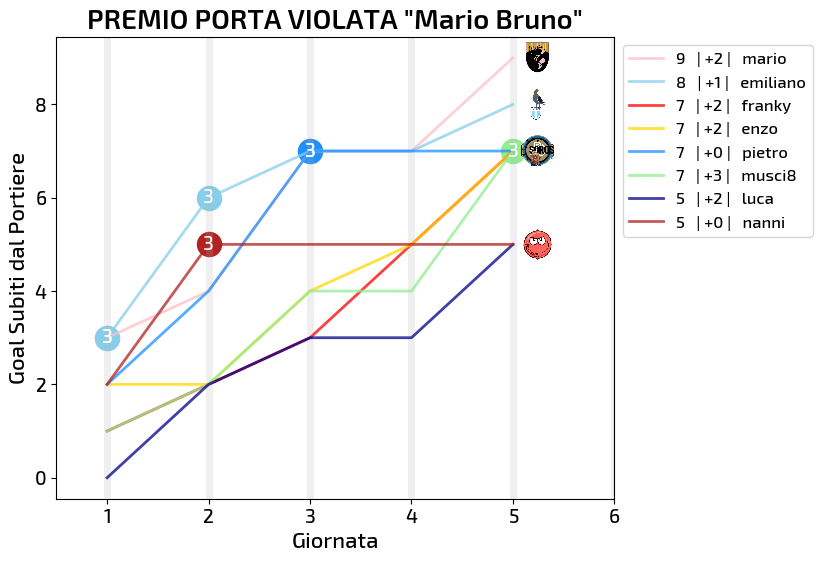

In [100]:
premio_plot(par='goal_subiti_por', title='PREMIO PORTA VIOLATA "Mario Bruno"', ylabel='Goal Subiti dal Portiere')

['9.75   | +2.25 |   mario', '8.5   | +1.5 |   nanni', '6.5   | +0.0 |   emiliano', '5.25   | +0.0 |   enzo', '4.75   | +0.0 |   luca', '4.0   | +0.5 |   franky', '1.75   | +0.0 |   pietro', '1.75   | +0.0 |   musci8']


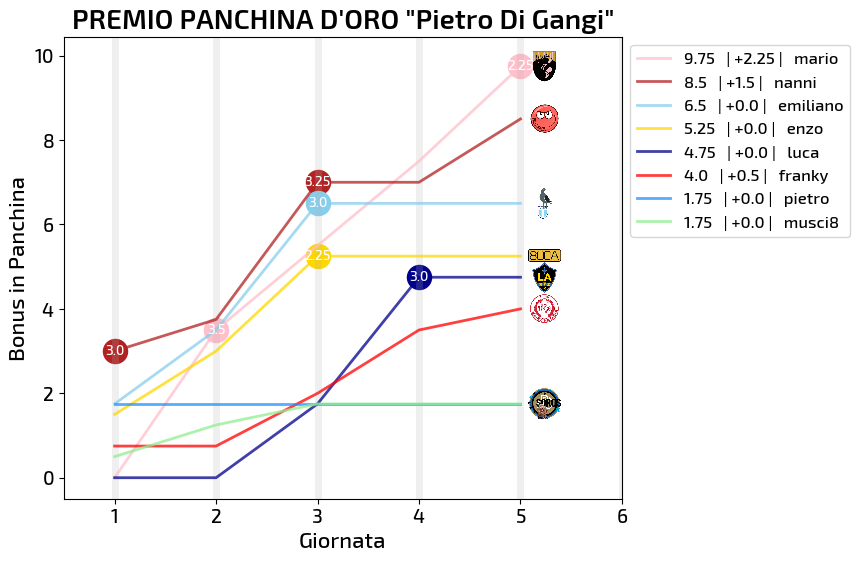

In [101]:
premio_plot(par='bonus_panchina', threshold=2, title='PREMIO PANCHINA D\'ORO "Pietro Di Gangi"', ylabel='Bonus in Panchina', integer=False)

['13   | +2 |   luca', '12   | +4 |   musci8', '11   | +3 |   enzo', '9   | +1 |   franky', '8   | +2 |   emiliano', '7   | +2 |   pietro', '7   | +1 |   mario', '6   | +2 |   nanni']


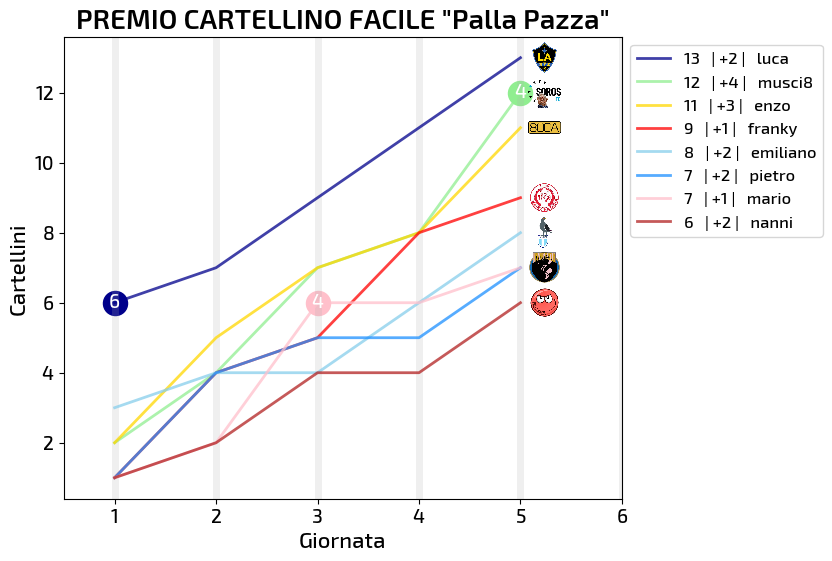

In [102]:
premio_plot(par='cartellini', threshold=3, title='PREMIO CARTELLINO FACILE "Palla Pazza"', ylabel='Cartellini') 

['23   | +4 |   luca', '21   | +3 |   pietro', '19   | +5 |   mario', '18   | +4 |   franky', '17   | +5 |   nanni', '17   | +5 |   enzo', '11   | +1 |   musci8', '9   | +3 |   emiliano']


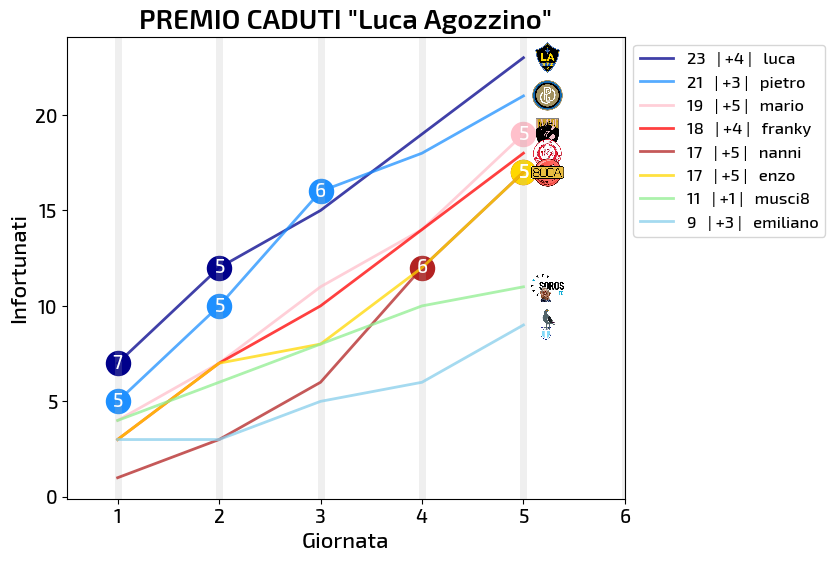

In [103]:
premio_plot(par='infortunati', threshold=4, title='PREMIO CADUTI "Luca Agozzino"', ylabel='Infortunati', integer=True) 

['4.0   | +0.0 |   mario', '3.5   | +1.0 |   emiliano', '3.0   | +0.5 |   enzo', '2.5   | +0.5 |   nanni', '0.5   | +0.0 |   luca', '0.0   | +0.0 |   franky', '0.0   | +0.0 |   pietro', '0.0   | +0.0 |   musci8']


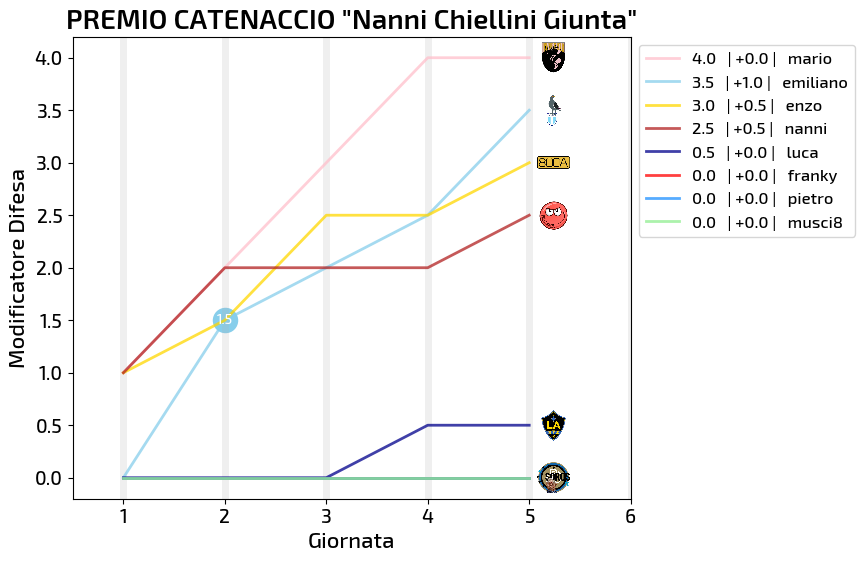

In [104]:
premio_plot(par='mod_difesa', threshold=1., title='PREMIO CATENACCIO "Nanni Chiellini Giunta"', ylabel='Modificatore Difesa', integer=False) 

# [>] Box plots

# [>] Andamento punti fatti/subiti

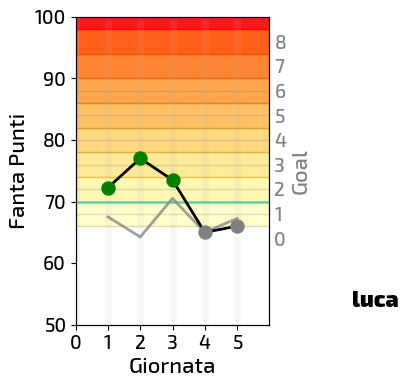

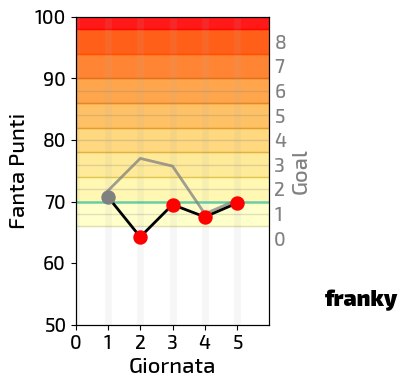

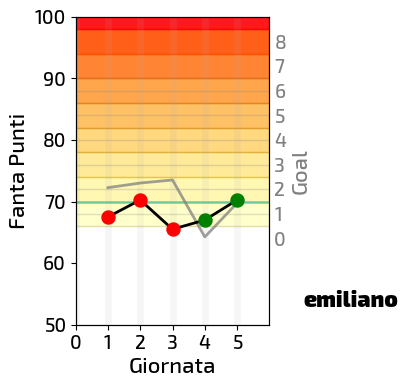

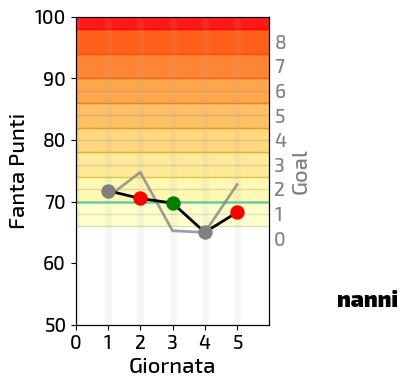

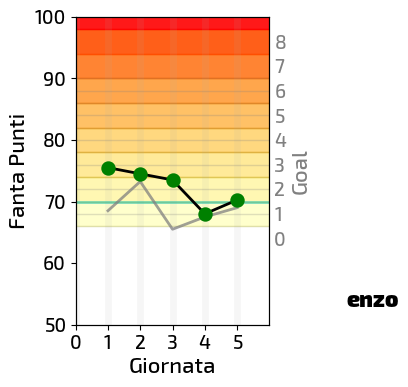

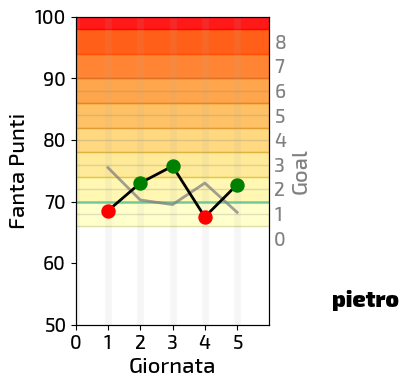

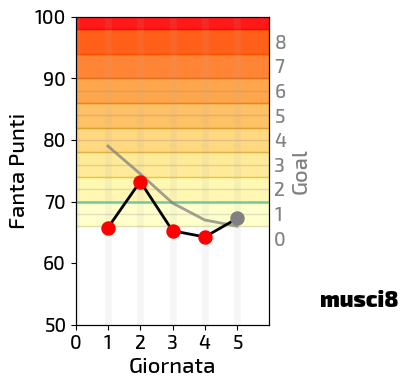

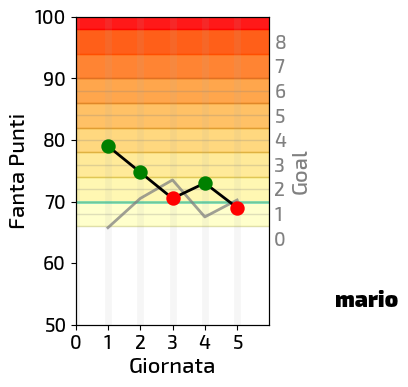

In [111]:
### Andamento per squadra ######################################################
import matplotlib.cm as cm

x = np.arange(8)
t = x

for team in Results.keys(): 
    data = Results[team]
    gg = max(data.index)
    
    fig = plt.figure(figsize=(gg*0.5,4))

    plt.hlines(goal_marks, -1000,1000, 'grey','-', linewidth=1, alpha=0.25)
    #plt.axhspan(pf_med-2*pf_std, pf_med+2*pf_std, 0, 40, color='blue', alpha=0.05, label='$2\sigma$')
    #plt.axhspan(pf_med-1*pf_std, pf_med+1*pf_std, 0, 40, color='blue', alpha=0.1, label='$1\sigma$')
    plt.hlines(pf_med,0,40, colors='c', linewidth=2, linestyles='-', alpha=0.5, label='Median')

    
    plt.fill_between([0,100], [66,66], [70,70], color=(1,1,0), alpha=0.2)
    plt.fill_between([0,100], [70,70], [74,74], color=(1,.9,0), alpha=0.3)
    plt.fill_between([0,100], [74,74], [78,78], color=(1,.8,0), alpha=0.4)
    plt.fill_between([0,100], [78,78], [82,82], color=(1,.7,0), alpha=0.5)
    plt.fill_between([0,100], [82,82], [86,86], color=(1,.6,0), alpha=0.6)
    plt.fill_between([0,100], [86,86], [90,90], color=(1,.5,0), alpha=0.7)
    plt.fill_between([0,100], [90,90], [94,94], color=(1,.4,0), alpha=0.8)
    plt.fill_between([0,100], [94,94], [98,98], color=(1,.3,0), alpha=0.9)
    plt.fill_between([0,100], [98,98], [102,102], color=(1,0,0), alpha=0.9)
    



    
    data = Results[team]
    ax = plt.plot(data.index, data['punti_subiti'], c='grey', linestyle='-', linewidth=2, alpha=.75)
    ax = plt.plot(data.index, data['punti_fatti'], c='black', linestyle='-', linewidth=2)

    #ax = plt.scatter(data.index, data['punti_subiti'], c='blue', s=data['punti_subiti'], alpha=0.1)
    data = Results[team][Results[team].esito=='S']  
    ax = plt.scatter(data.index, data['punti_fatti'], c='r', edgecolor='r', linestyle='-', linewidth=2, s=70, label='', zorder=10)
    #ax = plt.scatter(data.index, data['punti_subiti'], c='black', edgecolor='none', s=50, alpha=0.25, label='')
    data = Results[team][Results[team].esito=='P']
    ax = plt.scatter(data.index, data['punti_fatti'], c='grey', edgecolor='grey',  linestyle='-', linewidth=2, s=70, label='', zorder=10)
    #ax = plt.scatter(data.index, data['punti_subiti'], c='black', edgecolor='none', s=50, alpha=0.25, label='')
    data = Results[team][Results[team].esito=='V']
    ax = plt.scatter(data.index, data['punti_fatti'], c='g', edgecolor='g', linestyle='-', linewidth=2, s=70, label='', zorder=10)
    #ax = plt.scatter(data.index, data['punti_subiti'], c='black', edgecolor='none', s=50, alpha=0.25, label='')

    plt.xlabel('Giornata')
    plt.ylabel('Fanta Punti')
    plt.text(10,53,team, horizontalalignment='right', fontweight='1000')

    giornata=gg+1
    ymin = 50
    ymax = 100
    plt.xlim(0,giornata)
    plt.ylim(ymin, ymax)
    plt.xticks(np.arange(0,giornata))
    plt.grid(axis='x', linestyle='-', linewidth=5, alpha=0.1)
    #plt.minorticks_on()
    
    # secondary y axis
    ax2 = plt.twinx()
    goal = lambda fp: (fp-66)/4 + 0.5 
    #ymin, ymax = plt.axes.get_ylim()
    ax2.set_ylim((goal(ymin),goal(ymax)))
    ax2.set_yticks([0,1,2,3,4,5,6,7,8])
    ax2.set_ylabel('Goal')
    ax2.tick_params(axis='y', colors='grey', length=0)
    ax2.yaxis.label.set_color('grey')
    ax2.plot([],[])
  
    plt.show()

# [>] Scores sotto la media

In [105]:
def print_low_scoring_results():
    media, giornate = [], []
    for team, df in Results.items():
        print('\n###', team, '###')
        pti=0
        g = 0
        for gg in df.index:     
            if ((df['punti_fatti'][gg]<pf_med) & (df['punti_fatti'][gg]>=62)):
                res = esito(df.GF[gg], df.GS[gg])
                print('G', gg, ':', df.punti_fatti[gg], '|', res, '(', df.GF[gg], '-', df.GS[gg], ')')
                pti = pti+punti(res)
                g = g+1
        print('--->', pti, 'punti in', g, 'giornate ( media:', pti/g,')')
        media.append(pti/g)
        giornate.append(g)
    return media, giornate
        
        

        
        
def print_very_low_scoring_results():
    for team, df in Results.items():
        print('\n###', team, '###')
        pti=0
        g = 0
        for gg in df.index:     
            if df['punti_fatti'][gg]<62:
                res = esito(df.GF[gg], df.GS[gg])
                print('G', gg, ':', df.punti_fatti[gg], '|', res, '(', df.GF[gg], '-', df.GS[gg], ')')
                pti = pti+punti(res)
                g = g+1
        try:
            print('--->', pti, 'punti in', g, 'giornate ( media:', pti/g,')')
        except:
            print('No games < 62 fantapunti found')
            
            
            
def print_high_scoring_results():
    media, giornate = [], []
    for team, df in Results.items():
        print('\n###', team, '###')
        pti=0
        g = 0
        for gg in df.index:     
            if (df['punti_fatti'][gg]>=74):
                res = esito(df.GF[gg], df.GS[gg])
                print('G', gg, ':', df.punti_fatti[gg], '|', res, '(', df.GF[gg], '-', df.GS[gg], ')')
                pti = pti+punti(res)
                g = g+1
        print('--->', pti, 'punti in', g, 'giornate ( media:', pti/g,')')
        media.append(pti/g)
        giornate.append(g)
    return media, giornate


def print_great_opponent(punti_subiti=82):
    media, giornate = [], []
    for team, df in Results.items():
        print('\n###', team, '###')
        pti=0
        g = 0.000000001
        ps = 0
        for gg in df.index:     
            if (df['punti_subiti'][gg]>=punti_subiti):
                res = esito(df.GF[gg], df.GS[gg])
                print('G', gg, ':', df.punti_fatti[gg], '|', res, '(', df.GF[gg], '-', df.GS[gg], ')')
                pti = pti+punti(res)
                ps = ps + df['punti_subiti'][gg]
                g = g+1
        print('--->', pti, 'punti in', g, 'giornate ( media:', pti/g,')')
        media.append(ps/g)
        giornate.append(g)
    return media, giornate


### luca ###
G 4 : 65.0 | P ( 0 - 0 )
G 5 : 66.0 | P ( 1 - 1 )
---> 2 punti in 2 giornate ( media: 1.0 )

### franky ###
G 2 : 64.25 | S ( 0 - 6 )
G 3 : 69.5 | S ( 2 - 5 )
G 4 : 67.5 | S ( 1 - 2 )
G 5 : 69.75 | S ( 2 - 3 )
---> 0 punti in 4 giornate ( media: 0.0 )

### emiliano ###
G 1 : 67.5 | S ( 1 - 4 )
G 3 : 65.5 | S ( 0 - 4 )
G 4 : 67.0 | V ( 1 - 0 )
---> 3 punti in 3 giornate ( media: 1.0 )

### nanni ###
G 3 : 69.75 | V ( 2 - 0 )
G 4 : 65.0 | P ( 0 - 0 )
G 5 : 68.25 | S ( 2 - 4 )
---> 4 punti in 3 giornate ( media: 1.3333333333333333 )

### enzo ###
G 4 : 68.0 | V ( 2 - 1 )
---> 3 punti in 1 giornate ( media: 3.0 )

### pietro ###
G 1 : 68.5 | S ( 2 - 5 )
G 4 : 67.5 | S ( 1 - 4 )
---> 0 punti in 2 giornate ( media: 0.0 )

### musci8 ###
G 1 : 65.75 | S ( 0 - 7 )
G 3 : 65.25 | S ( 0 - 2 )
G 4 : 64.25 | S ( 0 - 1 )
G 5 : 67.25 | P ( 1 - 1 )
---> 1 punti in 4 giornate ( media: 0.25 )

### mario ###
G 5 : 69.0 | S ( 2 - 3 )
---> 0 punti in 1 giornate ( media: 0.0 )


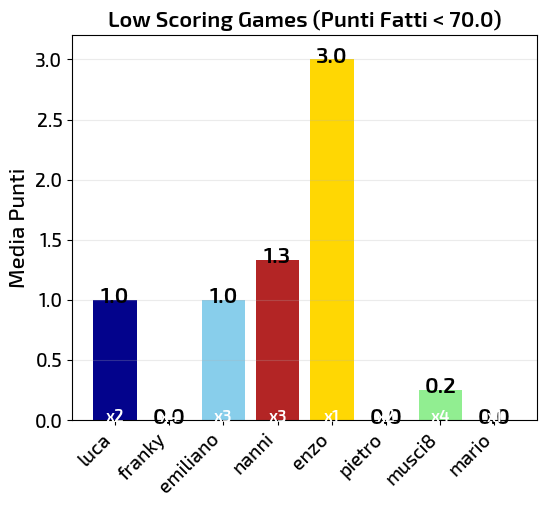

In [106]:
media, partite = print_low_scoring_results()

fig = plt.figure(figsize=(6,5))
plt.grid(which='major', axis='y', ls='-', alpha=0.25)
xlabels = Total['Team']
plt.xticks(Total.index, xlabels, rotation=45, ha='right')
#plt.axhline(y=0, xmin=-100, xmax=100, color='grey', ls='-')

max_f = max(Total['IndiceFortuna'])
min_f = np.min(Total['IndiceFortuna'])
colors = get_team_colors()
plt.bar(np.arange(0,8), media, color=colors, lw=0, alpha=0.99, width=0.8, label='')

for i, m in enumerate(list(media)):
    va = 'top'
    offset = 0.1
    plt.annotate(np.round(m, decimals=1), (i, m+1*offset), horizontalalignment='center', verticalalignment=va, weight='bold')
    plt.annotate('x' + str(partite[i]), (i, 0+1*offset), horizontalalignment='center', verticalalignment=va, fontsize=12, color='white', weight='bold')

plt.ylim(0, max(media)+2*offset)
plt.ylabel('Media Punti')
title = 'Low Scoring Games (Punti Fatti < %.1f)' % pf_med
plt.title(title)
plt.show()

In [107]:
print_very_low_scoring_results()


### luca ###
No games < 62 fantapunti found

### franky ###
No games < 62 fantapunti found

### emiliano ###
No games < 62 fantapunti found

### nanni ###
No games < 62 fantapunti found

### enzo ###
No games < 62 fantapunti found

### pietro ###
No games < 62 fantapunti found

### musci8 ###
No games < 62 fantapunti found

### mario ###
No games < 62 fantapunti found


In [108]:
def print_1GF_results():
    for team, df in Results.items():
        print('\n###', team, '###')
        pti=0
        g = 0
        for gg in df.index:     
            if df['GF'][gg] == 1:
                res = esito(df.GF[gg], df.GS[gg])
                print('G', gg, ':', df.punti_fatti[gg], '|', res, '(', df.GF[gg], '-', df.GS[gg], ')')
                pti = pti+punti(res)
                g = g+1
        try:
            print('--->', pti, 'punti in', g, 'giornate ( media:', pti/g,')')
        except: 
            print('No games found with GF<=1')

In [109]:
print_1GF_results()


### luca ###
G 5 : 66.0 | P ( 1 - 1 )
---> 1 punti in 1 giornate ( media: 1.0 )

### franky ###
G 4 : 67.5 | S ( 1 - 2 )
---> 0 punti in 1 giornate ( media: 0.0 )

### emiliano ###
G 1 : 67.5 | S ( 1 - 4 )
G 4 : 67.0 | V ( 1 - 0 )
---> 3 punti in 2 giornate ( media: 1.5 )

### nanni ###
No games found with GF<=1

### enzo ###
No games found with GF<=1

### pietro ###
G 4 : 67.5 | S ( 1 - 4 )
---> 0 punti in 1 giornate ( media: 0.0 )

### musci8 ###
G 5 : 67.25 | P ( 1 - 1 )
---> 1 punti in 1 giornate ( media: 1.0 )

### mario ###
No games found with GF<=1


In [110]:
media, partite = print_high_scoring_results()

fig = plt.figure(figsize=(6,5))
plt.grid(which='major', axis='y', ls='-', alpha=0.25)
xlabels = Total['Team']
plt.xticks(Total.index, xlabels, rotation=45, ha='right')
#plt.axhline(y=0, xmin=-100, xmax=100, color='grey', ls='-')

max_f = max(Total['IndiceFortuna'])
min_f = np.min(Total['IndiceFortuna'])
colors = get_team_colors()
plt.bar(np.arange(0,8), media, color=colors, lw=0, alpha=0.99, width=0.8, label='')

for i, m in enumerate(list(media)):
    va = 'top'
    offset = 0.2
    plt.annotate(np.round(m, decimals=1), (i, m+1*offset), horizontalalignment='center', verticalalignment=va, weight='bold')
    plt.annotate('x' + str(partite[i]), (i, 0+1*offset), horizontalalignment='center', verticalalignment=va, fontsize=12, color='white', weight='bold')

plt.ylim(0, max(media)+2*offset)
plt.ylabel('Media Punti')
title = 'High Scoring Games (Punti Fatti >= %.1f)' % 74
plt.title(title)
plt.show()


### luca ###
G 2 : 77.0 | V ( 6 - 0 )
---> 3 punti in 1 giornate ( media: 3.0 )

### franky ###


ZeroDivisionError: division by zero

In [ ]:
media, partite = print_great_opponent(82)

fig = plt.figure(figsize=(6,5))
plt.grid(which='major', axis='y', ls='-', alpha=0.25)
xlabels = Total['Team']
plt.xticks(Total.index, xlabels, rotation=45, ha='right')

colors = get_team_colors()
plt.bar(np.arange(0,8), media, color=colors, lw=0, alpha=0.99, width=0.8, label='')

min = 80.5
for i, m in enumerate(list(media)):
    va = 'top'
    offset = 0.4
    if m>0: plt.annotate(np.round(m, decimals=1), (i, m+1*offset), horizontalalignment='center', verticalalignment=va, weight='bold')
    plt.annotate('x%.0f' % partite[i], (i, min+1*offset), horizontalalignment='center', verticalalignment=va, fontsize=12, color='white', weight='bold')



plt.ylim(min, max(media)+2*offset)
plt.ylabel('Media Punti Subiti')
title = 'Exploit subiti (Goal Subiti >= 5)'
plt.title(title)
plt.show()

In [ ]:
###--- Melt dataframe with variables of interest ######################
def melt_df(variables = ['punti_subiti', 'punti_fatti']):
    data = []
    for team, df in Results.items():
        dd = pd.DataFrame()
        dd['Team'] = df['Team']
        for key in variables:
            dd[key] = df[key]
        data.append(dd)
    cdf = pd.concat(data)    
    mdf = pd.melt(cdf, id_vars=['Team'], var_name=['Variable'])
    return mdf

In [ ]:
### Box plot ##############################
data = melt_df(['punti_fatti'])

# box plot
ax = sns.boxplot(x="Team", y="value", hue="Variable", data=data, color='cyan', whis=1.5, width=0.5)    
# draw single datapoints
ax = sns.swarmplot(x="Team", y="value", hue="Variable", data=data, palette="Blues")    

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
#ax.set_ylim(-2,16)
ax.grid(axis='x', linestyle='-', linewidth=5, alpha=0.2)
ax.hlines(goal_marks, -1000,1000, 'grey','-', linewidth=1, alpha=0.5)
ax.hlines(ps_med,-100,100, colors='red', linewidth=1, linestyles='--', alpha=0.5, label='Median')


ax.set_ylabel('Fanta Punti')
ax.set_xlabel('')
ax.legend()

# secondary y axis
ax2 = ax.twinx()
goal = lambda fp: (fp-66)/4 + 0.5 
ymin, ymax = ax.get_ylim()
ax2.set_ylim((goal(ymin),goal(ymax)))
ax2.set_yticks([0,1,2,3,4,5,6,7,8])
ax2.set_ylabel('Goal')
ax2.tick_params(axis='y', colors='grey', length=0)
ax2.yaxis.label.set_color('grey')
ax2.plot([],[])

plt.show()

In [ ]:
### Box plot ##############################
data = melt_df(['punti_subiti'])

# box plot
ax = sns.boxplot(x="Team", y="value", hue="Variable", data=data, color='r', whis=1.5, width=0.5)    
# draw single datapoints
ax = sns.swarmplot(x="Team", y="value", hue="Variable", data=data, palette="Reds")    

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
#ax.set_ylim(-2,16)
ax.grid(axis='x', linestyle='-', linewidth=5, alpha=0.2)
ax.hlines(goal_marks, -1000,1000, 'grey','-', linewidth=1, alpha=0.5)
ax.hlines(ps_med,-100,100, colors='purple', linewidth=1, linestyles='--', alpha=0.5, label='Median')


ax.set_ylabel('Fanta Punti')
ax.set_xlabel('')
ax.legend()

# secondary y axis
ax2 = ax.twinx()
goal = lambda fp: (fp-66)/4 + 0.5 
ymin, ymax = ax.get_ylim()
ax2.set_ylim((goal(ymin),goal(ymax)))
ax2.set_yticks([0,1,2,3,4,5,6,7,8])
ax2.set_ylabel('Goal')
ax2.tick_params(axis='y', colors='grey', length=0)
ax2.yaxis.label.set_color('grey')
ax2.plot([],[])

plt.show()

In [ ]:
keys2print = ['Team', 'pos', 'rank', 'distacco', 'f_pos', 'f_distacco', 'f_GS', 'f_close_games', 'f_stolen_games', 'f_unlucky_opponent', 'IndiceFortuna']
data = Tot_per_round[11]
xxx = pd.DataFrame()
for key in keys2print:
    xxx[key] = data[key]
xxx

In [ ]:
data = Tot_per_round[12]
xxx = pd.DataFrame()
for key in keys2print:
    xxx[key] = data[key]
xxx